In [0]:
import torch
from IPython.display import clear_output

In [2]:
model = torch.hub.load('pytorch/vision', 'deeplabv3_resnet101', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_master


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(


In [0]:
clear_output()

In [0]:
#!pip install opencv-python

In [0]:
import urllib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
from PIL import Image
from torchvision import transforms
%matplotlib inline

In [5]:
mkdir work

mkdir: cannot create directory ‘work’: File exists


In [0]:
foreground1 = 'https://live.staticflickr.com/1399/1118093174_8b723e1ee5_o.jpg' #@param {type:"string"}
#foreground2 = 'https://unsplash.com/photos/dGMcpbzcq1I.jpg' #@param {type:"string"}
BACKGROUND = 'https://live.staticflickr.com/7860/46618564664_be235e82e8_b.jpg' #@param {type:"string"}

In [0]:
url, filename = (BACKGROUND, "work/background.jpg")

In [0]:
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [0]:
background = Image.open(filename).convert("RGB")
background.save('work/background.jpg')

In [0]:
url, filename = (foreground1, "work/foreground.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

foreground = Image.open(filename).convert("RGB")
foreground.save('work/foreground.jpg')

In [0]:
#url, filename = (foreground2, "work/foreground2.jpg")
#try: urllib.URLopener().retrieve(url, filename)
#except: urllib.request.urlretrieve(url, filename)

#foreground2 = Image.open(filename).convert("RGB")
#foreground2.save('work/foreground2.jpg')

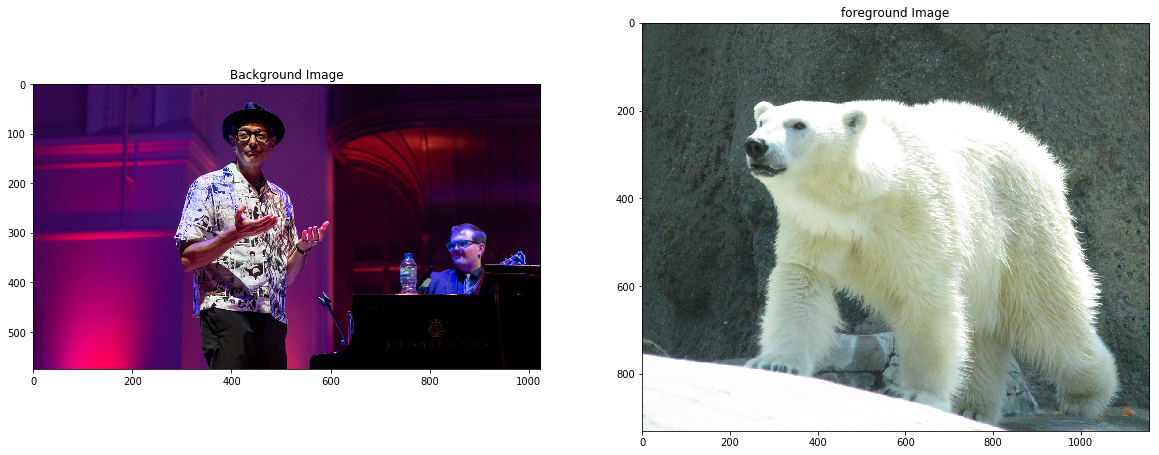

In [22]:
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(121)
ax1.imshow(background)
ax2 = fig.add_subplot(122)
ax2.imshow(foreground)
ax1.title.set_text('Background Image')
ax2.title.set_text('foreground Image')

In [0]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(foreground)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

In [0]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

In [0]:
# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(foreground.size)
r.putpalette(colors)
bw = r.convert('L')
bw.save('work/mask.png')

In [0]:
# crop out object
src1 = cv2.imread('work/foreground.jpg')
src1_mask = cv2.imread('work/mask.png')
ret,thresh1  = cv2.threshold(src1_mask,30,255,cv2.THRESH_BINARY)
src1 = cv2.cvtColor(src1,cv2.COLOR_RGB2BGR)
src1_mask = cv2.cvtColor(thresh1,cv2.COLOR_RGB2BGR)

In [19]:
mask_out=cv2.subtract(src1_mask,src1)
mask_out=cv2.subtract(src1_mask,mask_out)
cv2.imwrite('work/foreground.jpg',cv2.cvtColor(mask_out, cv2.COLOR_RGB2BGR))

True

In [20]:
# create mask
src = cv2.imread('work/mask.png', 1)
tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
thr,alpha = cv2.threshold(tmp,30,255,cv2.THRESH_BINARY)
b, g, r = cv2.split(src)
rgba = [b,g,r, alpha]
dst = cv2.merge(rgba,4)
cv2.imwrite("work/mask.png", dst)

True

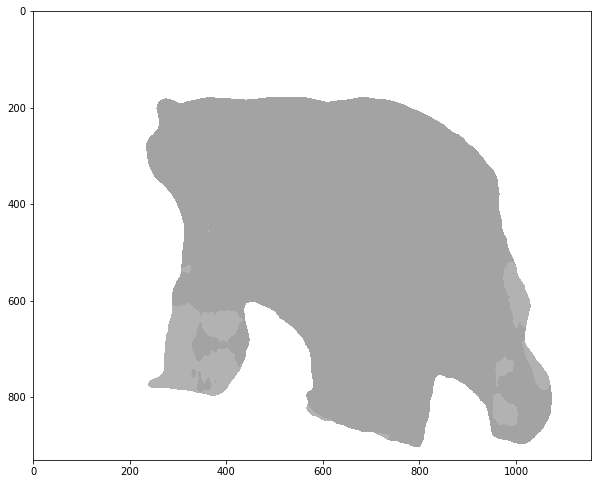

In [21]:
# mask generated
plt.figure(figsize=(10, 10))
plt.imshow(dst)

In [0]:
#@title Image Parameters
#@markdown ### Background Image Size:
BACKGROUND_HEIGHT = 512 #@param {type:"integer"}
BACKGROUND_WIDTH = 1024 #@param {type:"integer"}
#@markdown ### Foreground Image Size:
FOREGROUND_HEIGHT = 512 #@param {type:"integer"}
FOREGROUND_WIDTH = 512 #@param {type:"integer"}

In [23]:
def f(x,y):
  fig = plt.figure(figsize=(20, 20))

  ax1 = fig.add_subplot(111)
  background = Image.open('work/background.jpg')
  background = background.resize((BACKGROUND_WIDTH,BACKGROUND_HEIGHT))
  mouse = Image.open('work/foreground.jpg')
  mouse = mouse.resize((FOREGROUND_WIDTH,FOREGROUND_HEIGHT))
  mouse_mask = Image.open('work/mask.png')
  mouse_mask = mouse_mask.resize((FOREGROUND_WIDTH,FOREGROUND_HEIGHT))

  background.paste(mouse, (x,y), mouse_mask)
  background.save('output.jpg')
  ax1.set_title('Output Image')
  plt.imshow(background)

h, w = background.size
print('Use these x,y sliders to adjust Foreground Image Placement\n')

interactive_plot = interactive(f, x=(-h, h, 10), y=(-w, w, 10))
output = interactive_plot.children[-1]
interactive_plot

Use these x,y sliders to adjust Foreground Image Placement



interactive(children=(IntSlider(value=-4, description='x', max=1024, min=-1024, step=10), IntSlider(value=-6, …

In [0]:
def maskgen(foreground,model):
	preprocess = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
	input_tensor = preprocess(Image.open(foreground).convert("RGB"))
	input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
	
	with torch.no_grad():
		output = model(input_batch)['out'][0]
	output_predictions = output.argmax(0)
	
	# create a color pallette, selecting a color for each class
	palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
	colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
	colors = (colors % 255).numpy().astype("uint8")
	
	# plot the semantic segmentation predictions of 21 classes in each color
	r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(Image.open(foreground).convert("RGB").size)
	r.putpalette(colors)
	bw = r.convert('L')
	bw.save(foreground.split('.')[0]+'_mask.png')
	
	# crop out object
	src1 = cv2.imread(foreground)
	src1_mask = cv2.imread(foreground.split('.')[0]+'_mask.png')
	ret,thresh1  = cv2.threshold(src1_mask,30,255,cv2.THRESH_BINARY)
	src1 = cv2.cvtColor(src1,cv2.COLOR_RGB2BGR)
	src1_mask = cv2.cvtColor(thresh1,cv2.COLOR_RGB2BGR)

	mask_out=cv2.subtract(src1_mask,src1)
	mask_out=cv2.subtract(src1_mask,mask_out)
	cv2.imwrite(foreground,cv2.cvtColor(mask_out, cv2.COLOR_RGB2BGR))
	
	# create mask
	src = cv2.imread(foreground.split('.')[0]+'_mask.png', 1)
	tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
	thr,alpha = cv2.threshold(tmp,30,255,cv2.THRESH_BINARY)
	b, g, r = cv2.split(src)
	rgba = [b,g,r, alpha]
	dst = cv2.merge(rgba,4)
	cv2.imwrite(foreground.split('.')[0]+'_mask.png', dst)
	
	

In [24]:
maskgen('work/foreground.jpg',model)

KeyboardInterrupt: ignored

In [0]:
mask = Image.open('work/foreground_mask.png')

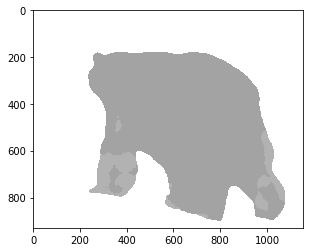

In [22]:
plt.imshow(mask)

In [0]:
#@title Image Parameters
#@markdown ### Background Image Size:
BACKGROUND_HEIGHT = 512 #@param {type:"integer"}
BACKGROUND_WIDTH = 1024 #@param {type:"integer"}
#@markdown ### Foreground Image Size:
FOREGROUND_HEIGHT = 512 #@param {type:"integer"}
FOREGROUND_WIDTH = 512 #@param {type:"integer"}

In [0]:
def img_clg(x,y,background,foreground):
	fig = plt.figure(figsize=(20, 20))
	ax1 = fig.add_subplot(111)
	background = Image.open(background)
	background = background.resize((BACKGROUND_WIDTH,BACKGROUND_HEIGHT))
	mouse = Image.open(foreground)
	mouse = mouse.resize((FOREGROUND_WIDTH,FOREGROUND_HEIGHT))
	mouse_mask = Image.open(foreground.split('.')[0]+'_mask.png')
	mouse_mask = mouse_mask.resize((FOREGROUND_WIDTH,FOREGROUND_HEIGHT))

	background.paste(mouse, (x,y), mouse_mask)
	background.save('work/background.jpg')
	ax1.set_title('Output Image')
	plt.imshow(background)

In [38]:
h, w = background.size
print('Use these x,y sliders to adjust Foreground Image Placement\n')

interactive_plot = interactive(img_clg, x=(-h, h, 10), y=(-w, w, 10),background='work/background.jpg',foreground='work/foreground.jpg')
output = interactive_plot.children[-1]
interactive_plot

Use these x,y sliders to adjust Foreground Image Placement



interactive(children=(IntSlider(value=-4, description='x', max=1024, min=-1024, step=10), IntSlider(value=-6, …